<a href="https://colab.research.google.com/github/da-vincee09/sentiment_analysis_using_NLP/blob/main/sentiment_analysis_using_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sentiment Analysis on IMDB Movie Reviews Using Bag-of-Words and TF-IDF with TensorFlow Keras**

In this notebook, we perform **sentiment analysis** on movie reviews from the **IMDB dataset**, leveraging **Bag-of-Words (BoW)** and **TF-IDF** for feature extraction, and a **dense neural network** for classification. Sentiment analysis is a crucial natural language processing (NLP) task that determines whether a piece of text expresses a positive or negative opinion.  

---

## **Background**

Understanding audience sentiment is essential for applications such as:

* Movie and product recommendation systems  
* Marketing analytics and customer feedback analysis  
* Social media monitoring  

The **IMDB dataset** contains **50,000 movie reviews** labeled as **positive** or **negative**. Each review is preprocessed into a sequence of word indices, allowing feature extraction techniques like BoW and TF-IDF to represent text as numerical vectors suitable for machine learning models.  

Traditional approaches such as logistic regression or Naive Bayes can be applied to BoW features, but deep learning models provide higher flexibility and accuracy. By combining **vectorization techniques** with **dense neural networks**, we can capture complex patterns and word interactions to improve sentiment classification.

---

## **Objectives**

This notebook presents a comprehensive workflow for building, training, evaluating, and interpreting a sentiment analysis model. Specifically, we will:

### **1. Load and explore the dataset**

* Import the IMDB dataset from TensorFlow Keras
* Decode reviews from word indices to text
* Analyze dataset statistics and visualize label distribution
* Generate word clouds for positive and negative reviews

### **2. Extract features using Bag-of-Words and TF-IDF**

* Convert raw text into numerical representations using BoW and TF-IDF
* Limit vocabulary to the top 10,000 frequent words
* Compare feature dimensions and sparsity

### **3. Build and train a dense neural network**

* Construct a sequential network with hidden layers and dropout
* Train the network separately on BoW and TF-IDF features
* Use early stopping and learning rate reduction for stable training

### **4. Evaluate model performance**

* Predict sentiment on the test set
* Compute metrics such as **accuracy**, **precision**, **recall**, and **F1-score**
* Visualize results using confusion matrices

### **5. Visualize training and feature importance**

* Plot training and validation loss/accuracy curves
* Identify the most important words contributing to positive and negative predictions
* Display bar charts for interpretability

### **6. Compare BoW vs TF-IDF**

* Compare the accuracy and learning curves of both approaches
* Discuss which feature extraction method works better for IMDB sentiment analysis

---

> **By the end of this notebook**, you will have a fully functional sentiment analysis system capable of predicting review polarity, visualizing important words, and comparing feature extraction techniques for practical NLP applications.


In [1]:
# -------------------------------
# Install dependencies (only needed in Colab)
# -------------------------------
!pip install tensorflow matplotlib seaborn scikit-learn --quiet

# -------------------------------
# Core libraries
# -------------------------------
import os
import random
import numpy as np
import pandas as pd
import math

# -------------------------------
# Visualization
# -------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# Scikit-learn for metrics & feature extraction
# -------------------------------
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# -------------------------------
# TensorFlow / Keras
# -------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# -------------------------------
# Confirm imports
# -------------------------------
print("✅ All required libraries have been successfully imported.")

✅ All required libraries have been successfully imported.


# **Load and Decode IMDB Dataset**

* **Purpose**: Load the IMDB movie review dataset and decode pre-tokenized sequences into human-readable text for further processing. This allows us to perform feature extraction, modeling, and visual exploration of the data.

* **Dataset Details**:

  * Pre-tokenized sequences: Each review is already converted into a sequence of word indices.
  * `num_words=10000`: Only the top 10,000 most frequent words are kept; all other words are ignored.
  * Training set: 25,000 reviews with corresponding sentiment labels (`0 = negative`, `1 = positive`).
  * Test set: 25,000 reviews with labels.

* **Steps**:

  1. **Load dataset**:

     * Use `tensorflow.keras.datasets.imdb.load_data(num_words=10000)` to get tokenized training and testing data.
  2. **Create word-index mapping**:

     * `word_index` maps each word to an integer index.
     * `index_word` is the reverse mapping (integer → word), required to decode reviews.
  3. **Decode reviews**:

     * Function `decode_review(encoded_review)` converts integer sequences back to text.
     * Adjust for reserved indices in the IMDB dataset (`0, 1, 2`) by subtracting 3.
  4. **Decode all reviews**:

     * Apply decoding function to both training and testing datasets to produce `X_train_text` and `X_test_text`.

* **Verification**:

  * Print a sample review and its label to confirm correct loading and decoding.

* **Why important?**:

  1. **Human-readable data**: Essential for feature extraction methods like Bag-of-Words or TF-IDF.
  2. **Consistency**: Ensures the same dataset is used for modeling, EDA, and visualization.
  3. **Foundation for reproducibility**: Enables the creation of reproducible preprocessing pipelines and model training workflows.


In [2]:
# ================================================================
# LOAD DATASET
# ================================================================

from tensorflow.keras.datasets import imdb

# -------------------------------
# Load IMDB dataset
# -------------------------------
# The dataset is pre-tokenized: each review is a sequence of word indices
# num_words=10000 restricts to the top 10,000 most frequent words
(X_train_idx, y_train), (X_test_idx, y_test) = imdb.load_data(num_words=10000)

# -------------------------------
# Get word-index mappings
# -------------------------------
# word_index maps words to their integer indices
word_index = imdb.get_word_index()

# Reverse mapping: from index to word (needed for decoding reviews)
index_word = {v: k for k, v in word_index.items()}

# -------------------------------
# Decode reviews from integer sequences back to text
# -------------------------------
def decode_review(encoded_review):
    """
    Convert a sequence of integers back to a human-readable review string.
    Indices 0, 1, 2 are reserved in the IMDB dataset, so we subtract 3.
    """
    return ' '.join([index_word.get(i - 3, '?') for i in encoded_review])

# Decode all training and testing reviews
X_train_text = [decode_review(x) for x in X_train_idx]
X_test_text = [decode_review(x) for x in X_test_idx]

# -------------------------------
# Verify dataset loading
# -------------------------------
print("Sample review:", X_train_text[0])
print("Label:", y_train[0])


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Sample review: ? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big pr

# **Data Exploration and Visualization**

* **Purpose**: Understand the sentiment distribution and visualize commonly used words in positive and negative reviews. This helps identify patterns and informs feature extraction strategies.

* **Steps**:

  1. **Label Distribution**:

     * Use `sns.countplot` to visualize the number of positive (`1`) and negative (`0`) reviews in the training dataset.
     * Helps check for **class imbalance** and ensures balanced training.

  2. **Word Clouds**:

     * Concatenate all positive reviews into a single string (`positive_text`) and all negative reviews into another (`negative_text`).
     * Generate **WordClouds** to visually represent the most frequent words for each sentiment.
     * Positive word cloud highlights words commonly used in positive reviews.
     * Negative word cloud highlights words commonly used in negative reviews.
     * Side-by-side visualization allows easy comparison of word usage patterns.

* **Why important?**:

  1. **Insight into dataset**: Reveals which words contribute to sentiment classification.
  2. **Guides feature extraction**: Helps in choosing between BoW or TF-IDF and adjusting parameters like `max_features`.
  3. **Visual understanding**: Enhances interpretability and presentation quality for a project-level notebook.


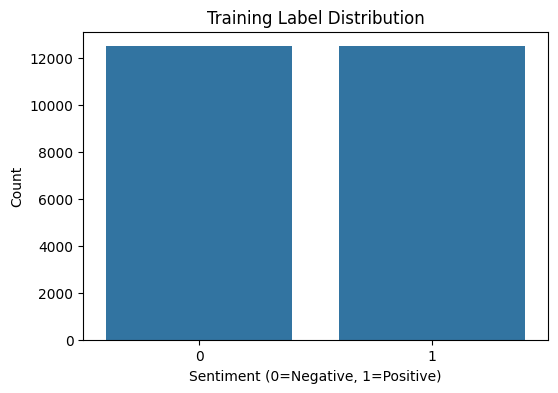

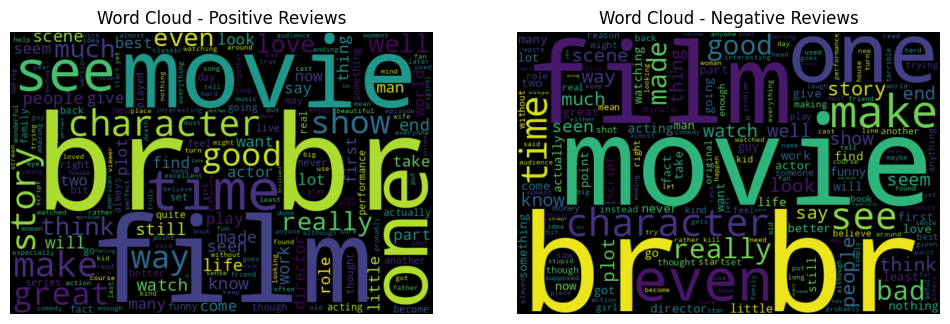

In [3]:
# ================================================================
# DATA EXPLORATION (with visuals)
# ================================================================

# -------------------------------
# Visualize label distribution
# -------------------------------
# Count how many positive (1) and negative (0) reviews are in the training set
plt.figure(figsize=(6,4))
sns.countplot(x=y_train)
plt.title("Training Label Distribution")
plt.xlabel("Sentiment (0=Negative, 1=Positive)")
plt.ylabel("Count")
plt.show()

# -------------------------------
# Generate Word Clouds for positive and negative reviews
# -------------------------------
from wordcloud import WordCloud

# Concatenate all positive and negative reviews separately
positive_text = " ".join([text for text, label in zip(X_train_text, y_train) if label==1])
negative_text = " ".join([text for text, label in zip(X_train_text, y_train) if label==0])

# Plot word clouds side-by-side
plt.figure(figsize=(12,6))

# Word cloud for positive reviews
plt.subplot(1,2,1)
WordCloud(width=600, height=400, background_color='white').generate(positive_text)
plt.imshow(WordCloud(width=600, height=400).generate(positive_text), interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Positive Reviews")

# Word cloud for negative reviews
plt.subplot(1,2,2)
WordCloud(width=600, height=400, background_color='white').generate(negative_text)
plt.imshow(WordCloud(width=600, height=400).generate(negative_text), interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Negative Reviews")

plt.show()

# **Feature Extraction: Bag-of-Words (BoW)**

* **Purpose**: Convert raw text reviews into numerical features suitable for machine learning. Bag-of-Words (BoW) captures the presence or frequency of words without considering word order.

* **Steps**:

  1. **Initialize CountVectorizer**:

     * `CountVectorizer(max_features=10000)` transforms text into a matrix of token counts.
     * `max_features=10000` limits the vocabulary to the 10,000 most frequent words, reducing dimensionality and computation.

  2. **Fit and transform training data**:

     * `fit_transform(X_train_text)` learns the vocabulary from the training set and converts each review into a BoW vector.

  3. **Transform test data**:

     * `transform(X_test_text)` converts test reviews using the **same vocabulary** learned from training, ensuring consistency between train and test sets.

* **Verification**:

  * `X_train_bow.shape` and `X_test_bow.shape` confirm the number of samples and features.
  * Each row corresponds to a review, and each column corresponds to a word feature.

* **Why important?**:

  1. **Simple and interpretable**: BoW is easy to implement and understand.
  2. **Baseline feature representation**: Provides a foundation for comparing with more advanced methods like TF-IDF.
  3. **Compatibility with neural networks**: Converts text into fixed-size vectors usable in Dense models.


In [4]:
# ================================================================
# FEATURE EXTRACTION: Bag-of-Words (BoW)
# ================================================================

# -------------------------------
# Initialize CountVectorizer
# -------------------------------
# Converts text documents into a matrix of token counts (BoW representation)
# max_features=10000 limits the vocabulary to the top 10,000 most frequent words
bow_vectorizer = CountVectorizer(max_features=10000)

# -------------------------------
# Fit vectorizer on training data and transform
# -------------------------------
# Learn the vocabulary from X_train_text and transform it into BoW feature matrix
X_train_bow = bow_vectorizer.fit_transform(X_train_text)

# Transform test data using the same vocabulary learned from training data
X_test_bow = bow_vectorizer.transform(X_test_text)

# -------------------------------
# Verify feature extraction
# -------------------------------
# Each row = one review, each column = one word feature
print("BoW feature shape (train):", X_train_bow.shape)
print("BoW feature shape (test):", X_test_bow.shape)

BoW feature shape (train): (25000, 9771)
BoW feature shape (test): (25000, 9771)


# **Feature Extraction: TF-IDF**

* **Purpose**: Transform text reviews into numerical features using **Term Frequency–Inverse Document Frequency (TF-IDF)**. TF-IDF not only counts words but also scales them based on their importance across the dataset, reducing the impact of common words.

* **Steps**:

  1. **Initialize TfidfVectorizer**:

     * `TfidfVectorizer(max_features=10000)` converts text into TF-IDF features.
     * `max_features=10000` limits the vocabulary to the 10,000 most informative words for efficiency.

  2. **Fit and transform training data**:

     * `fit_transform(X_train_text)` learns the vocabulary and IDF weights from the training set and converts reviews into TF-IDF vectors.

  3. **Transform test data**:

     * `transform(X_test_text)` converts test reviews using the **same vocabulary and IDF weights** learned from training, ensuring consistency.

* **Verification**:

  * `X_train_tfidf.shape` and `X_test_tfidf.shape` confirm the number of samples and features.
  * Each row corresponds to a review, and each column represents a TF-IDF weighted feature.

* **Why important?**:

  1. **Reduces impact of common words**: Words like "the" or "and" are down-weighted.
  2. **Captures word importance**: Rare but sentiment-relevant words carry more weight.
  3. **Improves model performance**: Often yields better results than plain BoW for classification tasks.
  4. **Compatibility with neural networks**: Produces fixed-size feature vectors for Dense models.


In [5]:
# ================================================================
# FEATURE EXTRACTION: TF-IDF
# ================================================================

# -------------------------------
# Initialize TfidfVectorizer
# -------------------------------
# Converts text documents into a matrix of TF-IDF features
# TF-IDF (Term Frequency–Inverse Document Frequency) scales word counts
# by how informative they are across all documents
# max_features=10000 limits vocabulary to the top 10,000 words
tfidf_vectorizer = TfidfVectorizer(max_features=10000)

# -------------------------------
# Fit vectorizer on training data and transform
# -------------------------------
# Learn the vocabulary and IDF weights from X_train_text
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)

# Transform test data using the same vocabulary and IDF weights
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

# -------------------------------
# Verify feature extraction
# -------------------------------
# Each row = one review, each column = one TF-IDF feature
print("TF-IDF feature shape (train):", X_train_tfidf.shape)
print("TF-IDF feature shape (test):", X_test_tfidf.shape)

TF-IDF feature shape (train): (25000, 9771)
TF-IDF feature shape (test): (25000, 9771)


# **Build Dense Neural Network Model**

* **Purpose**: Construct a fully connected neural network for **binary sentiment classification** on IMDB reviews, using either Bag-of-Words (BoW) or TF-IDF features.

* **Steps**:

  1. **Define model architecture**:

     * **Input layer**: Accepts `input_dim` features (depends on BoW or TF-IDF vector size).
     * **First hidden layer**: `Dense(128, activation='relu')` captures complex patterns in the data.
     * **Dropout(0.3)**: Reduces overfitting by randomly dropping 30% of neurons during training.
     * **Second hidden layer**: `Dense(64, activation='relu')` further refines learned representations.
     * **Dropout(0.3)**: Additional regularization.
     * **Output layer**: `Dense(1, activation='sigmoid')` produces a probability score for positive sentiment.

  2. **Compile the model**:

     * **Optimizer**: Adam, which adapts learning rates for faster convergence.
     * **Loss function**: `binary_crossentropy` suitable for two-class classification.
     * **Metric**: `accuracy` to evaluate model performance.

  3. **Instantiate separate models for BoW and TF-IDF**:

     ```python
     model_bow = build_model(input_dim=X_train_bow.shape[1])
     model_tfidf = build_model(input_dim=X_train_tfidf.shape[1])
     
     model_bow.summary()
     model_tfidf.summary()
     ```

* **Why important?**:

  1. Dense layers allow the network to learn nonlinear relationships between words/features and sentiment.
  2. Dropout prevents overfitting, which is crucial for high-dimensional text data.
  3. The sigmoid output layer ensures predictions are probabilities between 0 and 1, compatible with binary labels.
  4. Maintaining separate models for BoW and TF-IDF allows comparison of feature extraction methods on classification performance.

* **Verification**:

  * `model_bow.summary()` and `model_tfidf.summary()` display the number of parameters, layer types, and shapes, confirming the networks are correctly built.


In [6]:
# ================================================================
# BUILD DENSE NEURAL NETWORK MODEL
# ================================================================

# -------------------------------
# Function to build a neural network
# -------------------------------
def build_model(input_dim):
    """
    Builds and compiles a dense neural network for binary sentiment classification.

    Args:
        input_dim (int): Number of input features (depends on BoW or TF-IDF vector size)

    Returns:
        model: Compiled Keras Sequential model
    """

    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# -------------------------------
# Build model for BoW features
# -------------------------------
model_bow = build_model(input_dim=X_train_bow.shape[1])
model_bow.summary()

# -------------------------------
# Build model for TF-IDF features
# -------------------------------
model_tfidf = build_model(input_dim=X_train_tfidf.shape[1])
model_tfidf.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │     1,250,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,137 (4.80 MB)

 Trainable params: 1,259,137 (4.80 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │     1,250,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,137 (4.80 MB)

 Trainable params: 1,259,137 (4.80 MB)

 Non-trainable params: 0 (0.00 B)

# **Training the Dense Neural Network (BoW Features)**

* **Purpose**: Train the dense neural network using **Bag-of-Words features** and visualize training progress.

* **Steps**:

  1. **Define callbacks**:

     * **EarlyStopping**: Stops training if validation loss does not improve for 3 consecutive epochs and restores the best weights.
     * **ReduceLROnPlateau**: Reduces the learning rate by a factor of 0.5 if validation loss plateaus for 2 epochs, preventing overshooting and improving convergence.

  2. **Train the model**:

     * Input: BoW feature matrix (`X_train_bow.toarray()`) and labels (`y_train`).
     * Validation: 20% of training data is reserved for validation.
     * Epochs: 10, Batch size: 512.
     * Callbacks applied to control training.

  3. **Visualize training**:

     * **Loss curves**: Training vs. validation loss over epochs to monitor convergence.
     * **Accuracy curves**: Training vs. validation accuracy over epochs to check learning performance.

* **Why important?**:

  1. Callbacks like EarlyStopping prevent overfitting and save training time.
  2. Monitoring loss and accuracy helps to detect underfitting or overfitting.
  3. Visualization provides intuitive understanding of model learning dynamics.


Epoch 1/10
40/40 - 6s - 151ms/step - accuracy: 0.7775 - loss: 0.4768 - val_accuracy: 0.8802 - val_loss: 0.3207 - learning_rate: 1.0000e-03
Epoch 2/10
40/40 - 5s - 131ms/step - accuracy: 0.9092 - loss: 0.2475 - val_accuracy: 0.8882 - val_loss: 0.2974 - learning_rate: 1.0000e-03
Epoch 3/10
40/40 - 10s - 240ms/step - accuracy: 0.9409 - loss: 0.1714 - val_accuracy: 0.8878 - val_loss: 0.3109 - learning_rate: 1.0000e-03
Epoch 4/10
40/40 - 5s - 117ms/step - accuracy: 0.9625 - loss: 0.1099 - val_accuracy: 0.8872 - val_loss: 0.3276 - learning_rate: 1.0000e-03
Epoch 5/10
40/40 - 4s - 103ms/step - accuracy: 0.9809 - loss: 0.0650 - val_accuracy: 0.8862 - val_loss: 0.4014 - learning_rate: 5.0000e-04


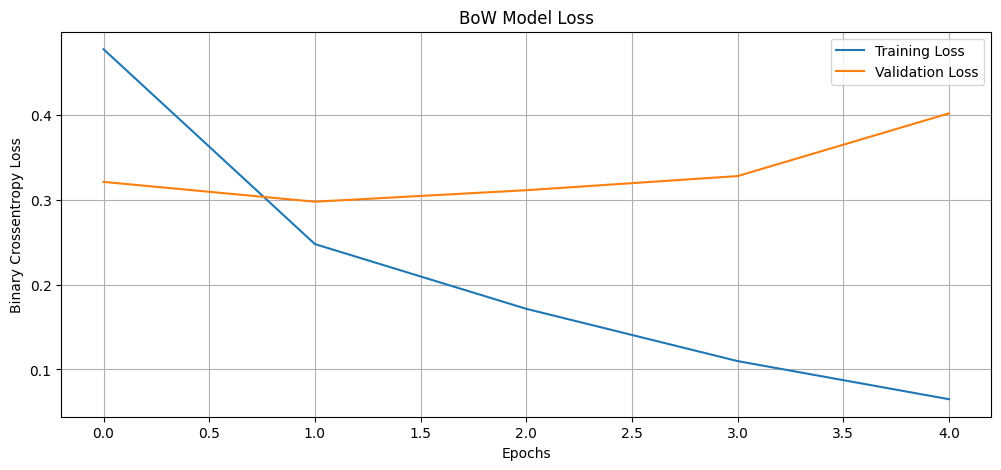

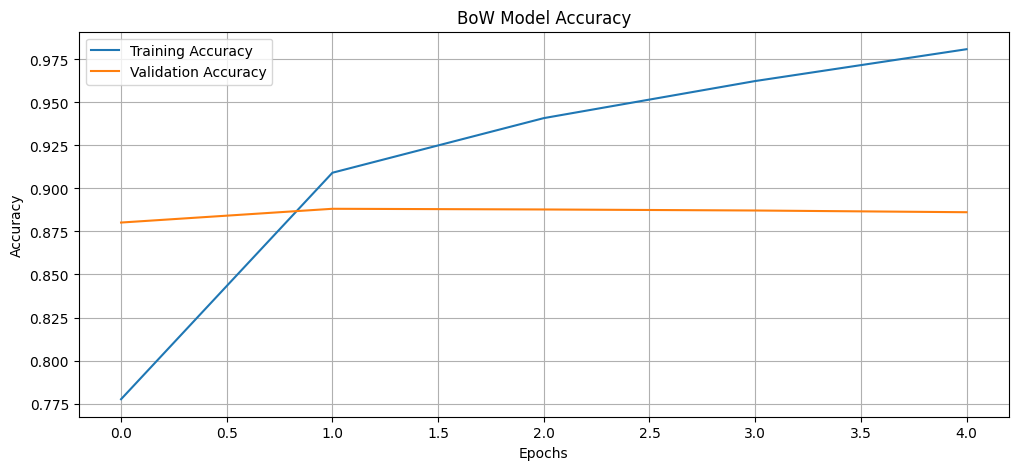

In [7]:
# ================================================================
# TRAINING + CALLBACKS (BoW) with loss/accuracy plots
# ================================================================

# -------------------------------
# Define callbacks for training
# -------------------------------
# EarlyStopping: stops training if validation loss doesn't improve for 3 epochs
# ReduceLROnPlateau: reduces learning rate if validation loss plateaus
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
]

# -------------------------------
# Train the model on BoW features
# -------------------------------
# Note: Convert sparse matrix to dense with .toarray() for Keras
history_bow = model_bow.fit(
    X_train_bow.toarray(), y_train,
    validation_split=0.2,   # Use 20% of training data for validation
    epochs=10,
    batch_size=512,
    callbacks=callbacks,
    verbose=2
)

# -------------------------------
# Plot training vs validation loss
# -------------------------------
plt.figure(figsize=(12,5))
plt.plot(history_bow.history['loss'], label='Training Loss')
plt.plot(history_bow.history['val_loss'], label='Validation Loss')
plt.title('BoW Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy Loss')
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# Plot training vs validation accuracy
# -------------------------------
plt.figure(figsize=(12,5))
plt.plot(history_bow.history['accuracy'], label='Training Accuracy')
plt.plot(history_bow.history['val_accuracy'], label='Validation Accuracy')
plt.title('BoW Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# **Evaluation of BoW Model with Confusion Matrix**

* **Purpose**: Evaluate the trained **Bag-of-Words (BoW)** model on the test set and visualize its performance.

* **Steps**:

  1. **Prediction**:

     * Use the trained `model_bow` to predict sentiment probabilities on the test set.
     * Convert probabilities to binary labels using a threshold of 0.5 (`>0.5 → 1, else 0`).

  2. **Compute Confusion Matrix**:

     * Compares predicted labels vs. true labels.
     * Provides counts of **True Positives (TP)**, **True Negatives (TN)**, **False Positives (FP)**, and **False Negatives (FN)**.

  3. **Visualize Confusion Matrix**:

     * Use a heatmap (`sns.heatmap`) for intuitive understanding.
     * Helps identify where the model is misclassifying positive or negative reviews.

  4. **Classification Report** (optional):

     * Shows **precision**, **recall**, **F1-score**, and support for each class.
     * Complements the confusion matrix by providing more detailed metrics.

* **Why important?**:

  1. Confusion matrix visually shows the types of errors the model makes.
  2. Metrics like precision and recall are crucial for understanding model performance beyond overall accuracy.
  3. Helps to compare different feature extraction methods (BoW vs TF-IDF) effectively.


782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


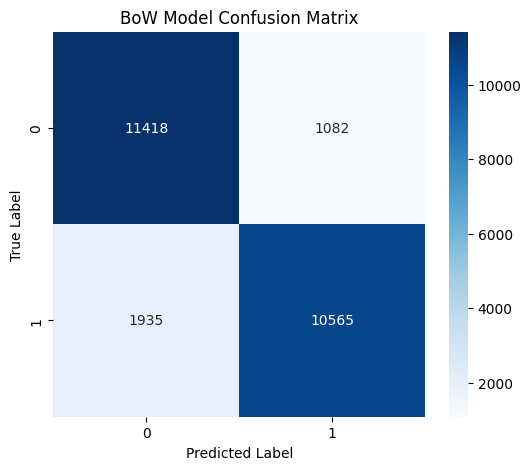

Classification Report (BoW Model):
              precision    recall  f1-score   support

    Negative       0.86      0.91      0.88     12500
    Positive       0.91      0.85      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



In [8]:
# ================================================================
# EVALUATION (BoW) with confusion matrix heatmap
# ================================================================

# -------------------------------
# Predict on test set using BoW model
# -------------------------------
# Threshold at 0.5 since sigmoid outputs probability
y_pred_bow = (model_bow.predict(X_test_bow.toarray()) > 0.5).astype(int)

# -------------------------------
# Generate confusion matrix
# -------------------------------
cm = confusion_matrix(y_test, y_pred_bow)

# -------------------------------
# Plot confusion matrix as heatmap
# -------------------------------
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.title("BoW Model Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# -------------------------------
# Optional: Print classification report
# -------------------------------
print("Classification Report (BoW Model):")
print(classification_report(y_test, y_pred_bow, target_names=['Negative', 'Positive']))


# **Evaluation of TF-IDF Model with Confusion Matrix**

* **Purpose**: Evaluate the trained **TF-IDF** model on the test set and visualize its performance.

* **Steps**:

  1. **Training**:

     * Train the neural network on **TF-IDF** features.
     * Use **EarlyStopping** and **ReduceLROnPlateau** callbacks to prevent overfitting and optimize learning rate.

  2. **Visualize Training**:

     * Plot **training vs. validation loss** to monitor convergence.
     * Plot **training vs. validation accuracy** to check learning progress.

  3. **Prediction**:

     * Use the trained `model_tfidf` to predict probabilities on the test set.
     * Convert probabilities to binary labels with a 0.5 threshold.

  4. **Compute Confusion Matrix**:

     * Compares predicted labels with true labels.
     * Helps identify **True Positives (TP)**, **True Negatives (TN)**, **False Positives (FP)**, and **False Negatives (FN)**.

  5. **Visualize Confusion Matrix**:

     * Use a heatmap (`sns.heatmap`) for intuitive interpretation.
     * Green color map emphasizes correct predictions.

  6. **Classification Report**:

     * Displays **precision**, **recall**, **F1-score**, and support for each class.
     * Complements the confusion matrix for detailed performance analysis.

* **Why important?**:

  1. TF-IDF often produces more informative features than BoW by weighing rare but important words higher.
  2. Visual comparison of confusion matrices between BoW and TF-IDF shows which feature extraction method yields better classification.
  3. Detailed metrics guide improvements in preprocessing, model design, and hyperparameters.


Epoch 1/10
40/40 - 7s - 165ms/step - accuracy: 0.7822 - loss: 0.5808 - val_accuracy: 0.8710 - val_loss: 0.3682 - learning_rate: 1.0000e-03
Epoch 2/10
40/40 - 4s - 91ms/step - accuracy: 0.8992 - loss: 0.2719 - val_accuracy: 0.8922 - val_loss: 0.2628 - learning_rate: 1.0000e-03
Epoch 3/10
40/40 - 5s - 119ms/step - accuracy: 0.9362 - loss: 0.1764 - val_accuracy: 0.8942 - val_loss: 0.2653 - learning_rate: 1.0000e-03
Epoch 4/10
40/40 - 6s - 146ms/step - accuracy: 0.9566 - loss: 0.1296 - val_accuracy: 0.8894 - val_loss: 0.2871 - learning_rate: 1.0000e-03
Epoch 5/10
40/40 - 3s - 77ms/step - accuracy: 0.9726 - loss: 0.0947 - val_accuracy: 0.8840 - val_loss: 0.3041 - learning_rate: 5.0000e-04


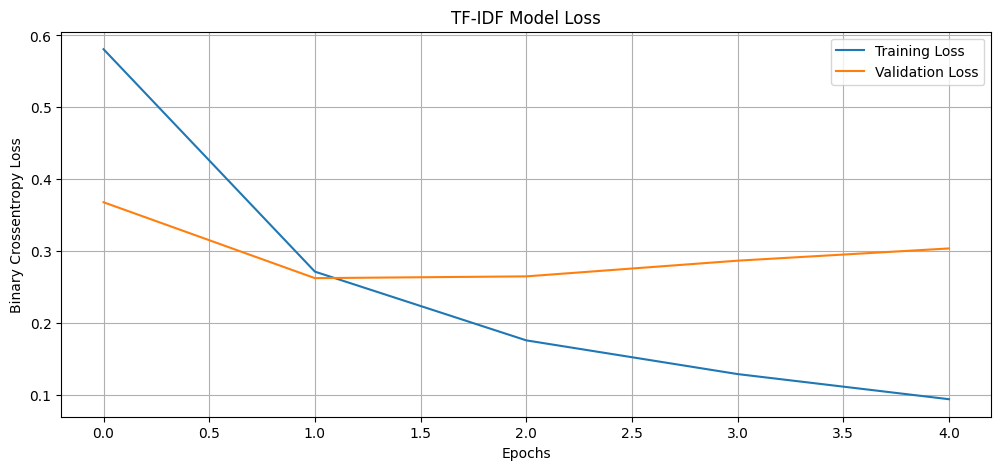

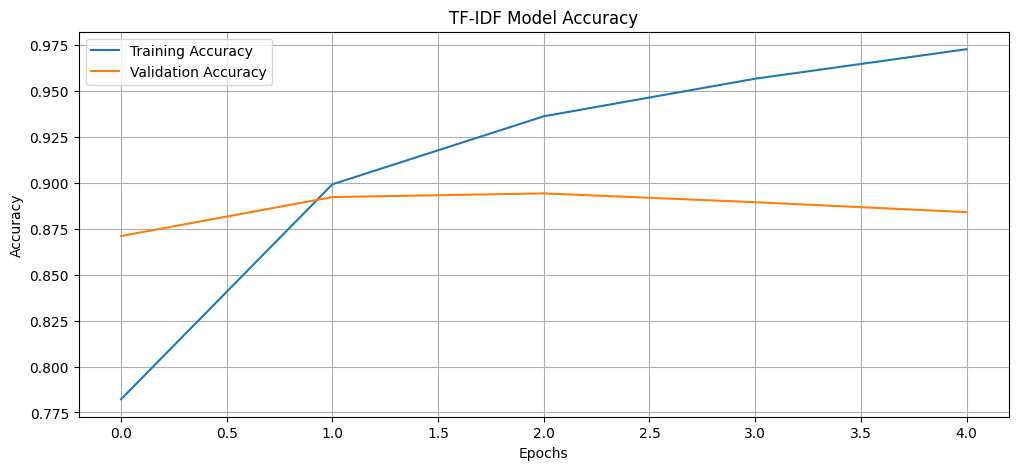

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


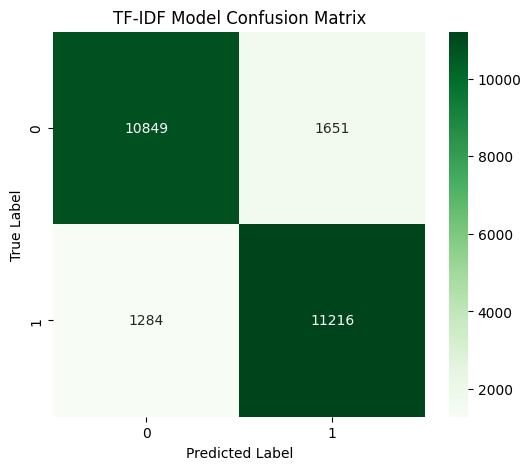

Classification Report (TF-IDF Model):
              precision    recall  f1-score   support

    Negative       0.89      0.87      0.88     12500
    Positive       0.87      0.90      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



In [9]:
# ================================================================
# TRAINING + EVALUATION (TF-IDF) with visuals
# ================================================================

# -------------------------------
# Train the model on TF-IDF features
# -------------------------------
# Note: Convert sparse matrix to dense with .toarray() for Keras
history_tfidf = model_tfidf.fit(
    X_train_tfidf.toarray(), y_train,
    validation_split=0.2,   # Use 20% of training data for validation
    epochs=10,
    batch_size=512,
    callbacks=callbacks,    # EarlyStopping & ReduceLROnPlateau
    verbose=2
)

# -------------------------------
# Plot training vs validation loss
# -------------------------------
plt.figure(figsize=(12,5))
plt.plot(history_tfidf.history['loss'], label='Training Loss')
plt.plot(history_tfidf.history['val_loss'], label='Validation Loss')
plt.title('TF-IDF Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy Loss')
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# Plot training vs validation accuracy
# -------------------------------
plt.figure(figsize=(12,5))
plt.plot(history_tfidf.history['accuracy'], label='Training Accuracy')
plt.plot(history_tfidf.history['val_accuracy'], label='Validation Accuracy')
plt.title('TF-IDF Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# Predict on test set using TF-IDF model
# -------------------------------
# Threshold at 0.5 for binary classification
y_pred_tfidf = (model_tfidf.predict(X_test_tfidf.toarray()) > 0.5).astype(int)

# -------------------------------
# Generate and plot confusion matrix
# -------------------------------
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf)
plt.figure(figsize=(6,5))
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Greens')
plt.title("TF-IDF Model Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# -------------------------------
# Optional: Print classification report
# -------------------------------
print("Classification Report (TF-IDF Model):")
print(classification_report(y_test, y_pred_tfidf, target_names=['Negative', 'Positive']))

# **Comparison of BoW vs TF-IDF Models**

* **Purpose**: Compare the performance of **Bag-of-Words (BoW)** and **TF-IDF** feature extraction approaches using the trained neural networks.

* **Steps**:

  1. **Compute Accuracy**:

     * Calculate the test set **accuracy** for both models.
     * `acc_bow` → Accuracy of BoW model
     * `acc_tfidf` → Accuracy of TF-IDF model

  2. **Visualize Comparison**:

     * Create a **bar chart** to directly compare accuracies.
     * Use a focused y-axis range (0.8–1.0) to highlight differences.

  3. **Interpretation**:

     * Higher accuracy indicates better feature representation for sentiment classification.
     * TF-IDF often performs slightly better due to weighting informative words more heavily.

* **Why important?**:

  1. Demonstrates the impact of feature engineering on model performance.
  2. Provides a **clear visual summary** of which text representation is more effective.
  3. Supports informed decisions for model selection in real-world NLP tasks.


/tmp/ipython-input-2342452284.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['BoW','TF-IDF'], y=[acc_bow, acc_tfidf], palette='viridis')


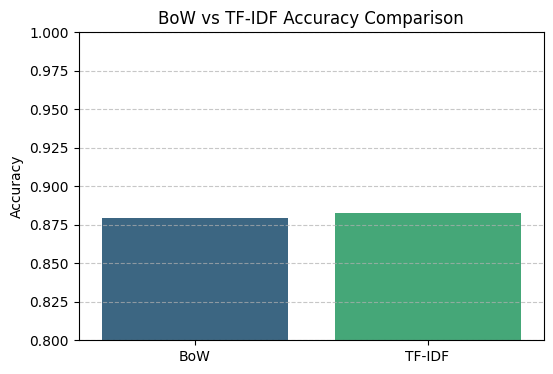

BoW Model Accuracy: 0.8793
TF-IDF Model Accuracy: 0.8826


In [10]:
# ================================================================
# COMPARISON OF BoW VS TF-IDF
# ================================================================

# -------------------------------
# Compute test accuracy for both models
# -------------------------------
acc_bow = accuracy_score(y_test, y_pred_bow)
acc_tfidf = accuracy_score(y_test, y_pred_tfidf)

# -------------------------------
# Plot a bar chart comparing accuracies
# -------------------------------
plt.figure(figsize=(6,4))
sns.barplot(x=['BoW','TF-IDF'], y=[acc_bow, acc_tfidf], palette='viridis')

# Set plot limits and labels
plt.ylim(0.8, 1.0)  # Focus on high-accuracy range for visibility
plt.ylabel('Accuracy')
plt.title('BoW vs TF-IDF Accuracy Comparison')

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# -------------------------------
# Optional: Print accuracies for clarity
# -------------------------------
print(f"BoW Model Accuracy: {acc_bow:.4f}")
print(f"TF-IDF Model Accuracy: {acc_tfidf:.4f}")

# **Most Important Words**

* **Purpose**: Identify and visualize the words that contribute the most to **positive** and **negative** sentiment predictions in the trained Dense NN model.

* **Methodology**:

  1. **Extract Weights**:

     * Retrieve the weights from the **first Dense layer** (input layer to first hidden layer).
     * Summing weights across neurons estimates each word's overall influence.

  2. **Map Words**:

     * Use the feature names from the **CountVectorizer or TF-IDF vectorizer** to map weight indices back to words.

  3. **Select Top Words**:

     * **Top Positive Words** → words with the largest positive weights
     * **Top Negative Words** → words with the largest negative weights (smallest weights)

  4. **Visualization**:

     * Horizontal **bar charts** for top positive (green) and negative (red) words.
     * Provides an intuitive view of which words most influence sentiment predictions.

* **Why important?**:

  1. Helps interpret the model and understand which words drive sentiment predictions.
  2. Supports model explainability, making it suitable for reports or presentations.
  3. Reveals insights into dataset patterns (e.g., common positive/negative words).

* **Usage Example**:

  ```python
  # Show top 20 positive and negative words for BoW model
  show_important_words(model_bow, bow_vectorizer, top_n=20)
  ```


Top 20 Positive Words:
 ['opportunity' 'acting' 'drivel' 'junior' 'fell' 'minimum' 'believe'
 'acted' 'unless' 'destroy' 'chewing' 'expresses' 'fails' 'costs'
 'daughter' 'wins' 'desires' 'guinness' 'olympic' 'thin']

Top 20 Negative Words:
 ['torn' 'particularly' 'testing' 'anticipated' 'wise' 'illiterate'
 'brendan' 'sleepy' 'passable' 'divine' 'though' 'launch' 'natural'
 'subtle' 'wrath' 'catches' 'referred' 'david' 'compound' 'fortunately']


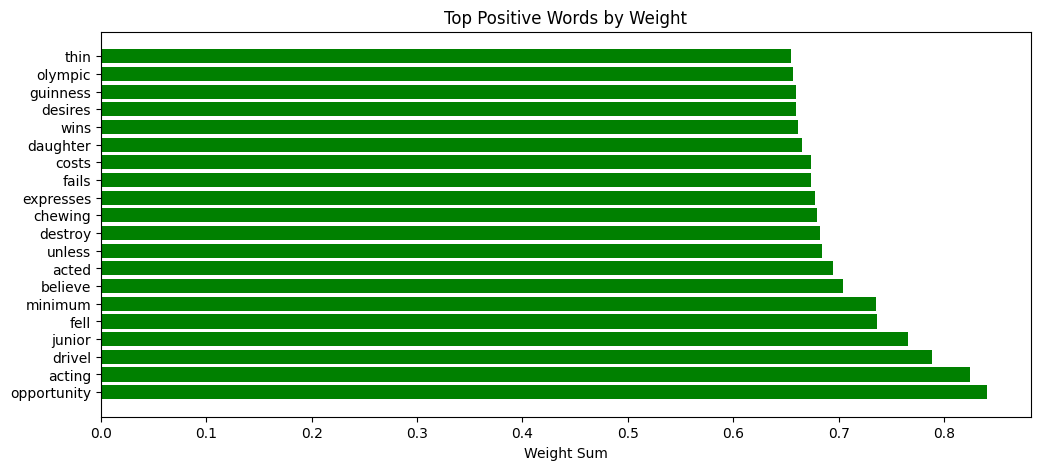

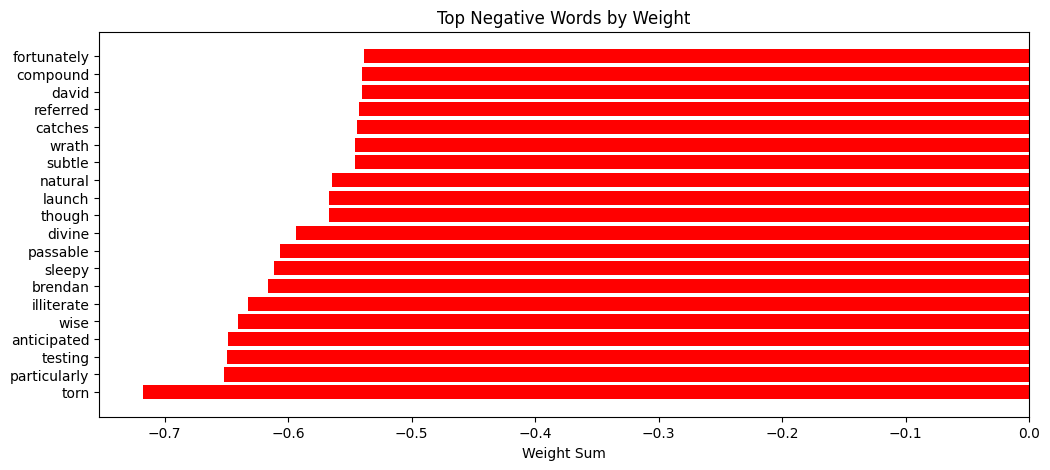

In [11]:
# ================================================================
# MOST IMPORTANT WORDS
# ================================================================

def show_important_words(model, vectorizer, top_n=20):
    """
    Displays and visualizes the top positive and negative words
    based on the learned weights of the trained Dense NN model.

    Args:
        model: Trained Keras model (Dense NN)
        vectorizer: CountVectorizer or TfidfVectorizer
        top_n: Number of top words to display for each sentiment
    """

    # -------------------------------
    # Get input layer weights
    # -------------------------------
    # We extract weights from the first Dense layer connecting input features to first hidden layer
    weights = model.layers[0].get_weights()[0]  # shape: (input_dim, hidden_units)

    # Sum weights across neurons to estimate overall importance of each word
    word_importance = np.sum(weights, axis=1)

    # Get feature names (words) from the vectorizer
    feature_names = np.array(vectorizer.get_feature_names_out())

    # -------------------------------
    # Identify top positive and negative words
    # -------------------------------
    top_pos_idx = np.argsort(word_importance)[-top_n:]  # largest weights
    top_pos_words = feature_names[top_pos_idx][::-1]   # reverse for descending order

    top_neg_idx = np.argsort(word_importance)[:top_n]  # smallest weights
    top_neg_words = feature_names[top_neg_idx]

    # Print top words
    print(f"Top {top_n} Positive Words:\n", top_pos_words)
    print(f"\nTop {top_n} Negative Words:\n", top_neg_words)

    # -------------------------------
    # Visualize top positive words
    # -------------------------------
    plt.figure(figsize=(12,5))
    plt.barh(range(top_n), word_importance[top_pos_idx][::-1], color='green')
    plt.yticks(range(top_n), top_pos_words)
    plt.title("Top Positive Words by Weight")
    plt.xlabel("Weight Sum")
    plt.show()

    # -------------------------------
    # Visualize top negative words
    # -------------------------------
    plt.figure(figsize=(12,5))
    plt.barh(range(top_n), word_importance[top_neg_idx], color='red')
    plt.yticks(range(top_n), top_neg_words)
    plt.title("Top Negative Words by Weight")
    plt.xlabel("Weight Sum")
    plt.show()

# -------------------------------
# Apply function to BoW model
# -------------------------------
show_important_words(model_bow, bow_vectorizer, top_n=20)